# Part of Speech Tagger, ~95% Accuracy using Glove
## This notebook trains a POS tagger model and save it as .h5 file
## The model achieves high accuracy using Glove words embedding

In [1]:
from nltk.corpus import conll2000
from nltk.corpus import brown
from nltk.corpus import treebank
import random
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import re
import sys
from pos_utilities import pos_utilities
import math

In [2]:
#import nltk
#nltk.download('all')
corpus = treebank.tagged_sents(tagset='universal')
corpus = corpus + brown.tagged_sents(tagset='universal')
corpus = corpus + conll2000.tagged_sents(tagset='universal')
print(f'treebank size {len(corpus)} sentences')

treebank size 72202 sentences


In [3]:
#Sampling of a random sentence and its tags
rand_id = random.randint(0, len(corpus)-1)
for sent_tuple in corpus[ rand_id ]:
    print(f'{ sent_tuple[0] }\t:\t{ sent_tuple[1] }')

A	:	DET
growl	:	NOUN
,	:	.
a	:	DET
nod	:	NOUN
,	:	.
was	:	VERB
usually	:	ADV
enough	:	ADJ
.	:	.


In [4]:
#splitting the corpus into 2 lists one for sentences and the other for each sentence tags
sentences = [] # all sentences
sentences_tags = [] # all sentences tags
sentences_raw = [] # words merged for each sentence with a space separator
all_words = [] # for analysis
all_tags = [] # for analyisis
lengths = [] # each sentence length list

#for sentenc_tagged in corpus:
for x in range (0,len(corpus)):
#for x in range (0,60000):
    sentence = []
    tags = []
    for word,tag in corpus[x]:
        sentence.append(word)
        tags.append(tag)
        all_words.append(word)
        all_tags.append(tag)
    sentences.append(sentence)
    sentences_tags.append(tags)
    lengths.append(len(sentence))
    sentences_raw.append(' '.join(sentence))

#X = np.array(sentences , dtype=object)
Y = np.asarray( sentences_tags )

print(f'{sentences[0]}')
print(f'{sentences_tags[0]}')

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.']


/tmp/ipykernel_3310/3600996854.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.asarray( sentences_tags )


count    72202.000000
mean        21.065511
std         12.914019
min          1.000000
25%         12.000000
50%         19.000000
75%         28.000000
max        271.000000
Name: lengths, dtype: float64
lengths
1     341
2     822
3    1146
4    1198
5    1476
dtype: int64


<AxesSubplot:xlabel='lengths'>

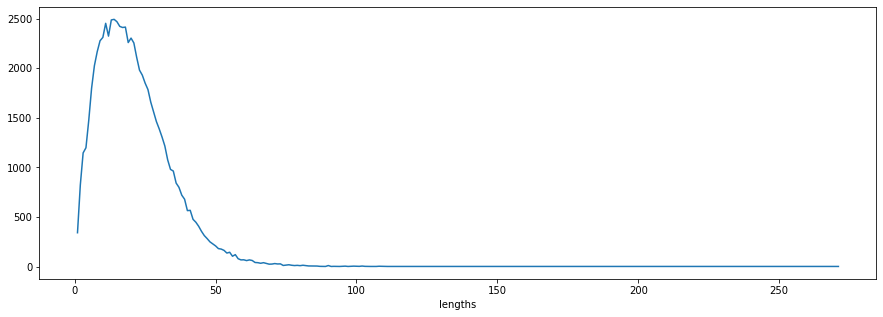

In [5]:
#lengths chart
df = pd.DataFrame()
df['lengths'] = lengths
print(df['lengths'].describe())
lengths_count = df.groupby('lengths').size()

print(lengths_count.head(5))
lengths_count.plot(figsize=(15,5))

In [6]:
# Tob build a robus model we will consider sentences of length 50 or less
#sentence average length in Wikipedia articles is 19
PADDING_SIZE = 100

sentences = [] # all sentences
sentences_tags = [] # all sentences tags
sentences_raw = [] # words merged for each sentence with a space separator
all_words = [] # for analysis
all_tags = [] # for analyisis
lengths = [] # each sentence length list

for x in range (0,len(corpus)):
    if len(corpus[x]) > PADDING_SIZE :
        continue
    sentence = []
    tags = []
    for word,tag in corpus[x]:
        sentence.append(word)
        tags.append(tag)
        all_words.append(word)
        all_tags.append(tag)
    sentences.append(sentence)
    sentences_tags.append(tags)
    lengths.append(len(sentence))
    sentences_raw.append(' '.join(sentence))

#X = np.array(sentences , dtype=object)
Y = np.asarray( sentences_tags )

/tmp/ipykernel_3310/1216268614.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.asarray( sentences_tags )


In [7]:
#remove duplicate words to get some statistics
all_words_df=pd.DataFrame(all_words) # to dataframe
all_words_df=all_words_df.groupby(all_words_df[0])
all_words_df.size()#.max()

0
!            1619
#              63
$            2781
$.027           2
$.03            4
             ... 
zoooop          1
zorrillas       1
zounds          2
zu              1
{0,T}           1
Length: 66833, dtype: int64

X : 7986
NUM : 28554
PRT : 41465
CONJ : 46767
PRON : 59530
ADV : 68360
ADJ : 107307
DET : 168973
ADP : 181736
. : 190246
VERB : 232848
NOUN : 381725


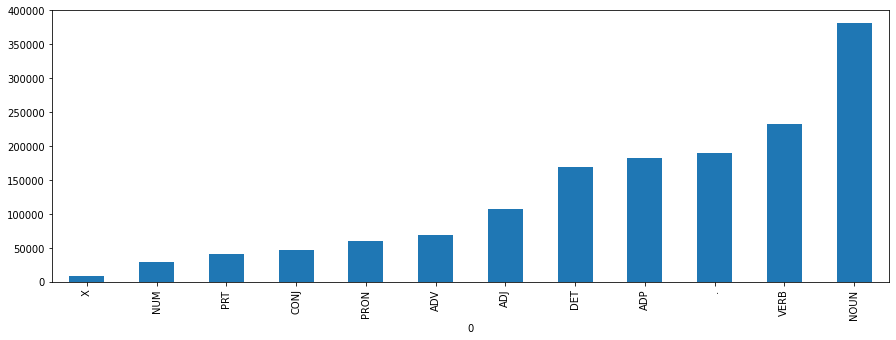

In [8]:
#tags chart
tags_df=pd.DataFrame(all_tags)
tags_grouped = tags_df.groupby(tags_df[0])
tags_df=tags_grouped.size().sort_values()
tags_df.plot.bar(figsize=(15,5))
for b in tags_df.keys():
    print(f"{b} : {tags_df[b]}")

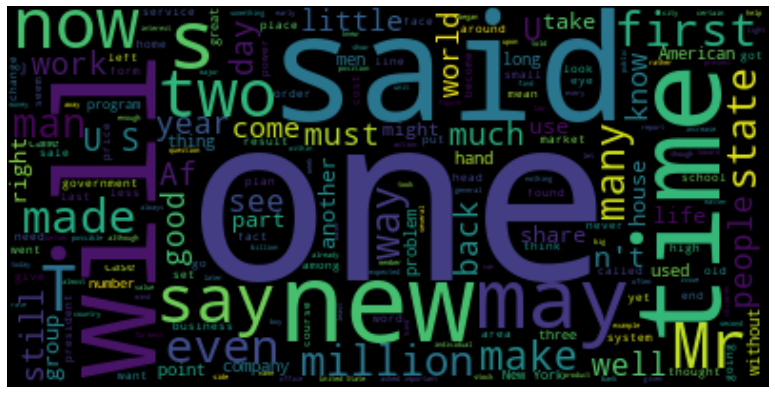

In [9]:
# Create and generate a word cloud image:
compine_string=(" ").join(all_words)

wordcloud = WordCloud().generate(compine_string)

# Display the generated image:
plt.figure(figsize = (20,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

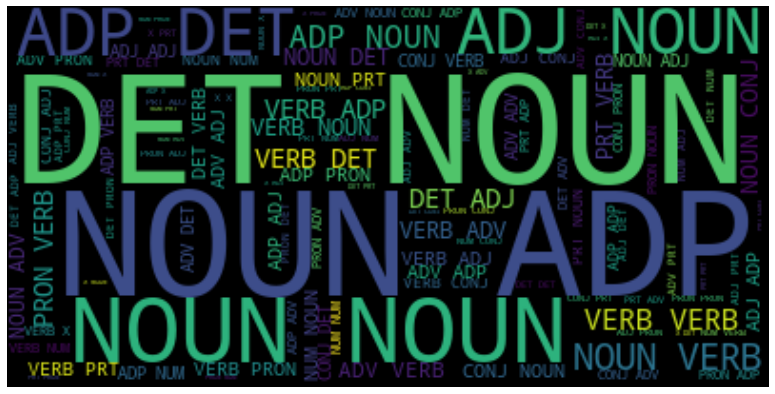

In [10]:
# Create and generate a word cloud image for the tags:
compine_string=(" ").join(all_tags)

wordcloud = WordCloud().generate(compine_string)

# Display the generated image:
plt.figure(figsize = (20,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [11]:
#embedding dimnesions constant based on Glove 50 model
EMBEDDING_DIMENSIONS = 50

In [12]:
# embedding using Glove

t = pos_utilities(PADDING_SIZE)

sentences_embedding = []
for sequence in sentences:
    sentences_embedding.append(t.sequence_embedding(sequence))

sentences_embedding = np.asarray( sentences_embedding ,
                                 dtype = np.float32 #float32 fits memory better
                                )
print(sentences_embedding.shape)

(72158, 100, 50)


In [13]:
#check variables with large memory space
print (f"sentences_embedding { sys.getsizeof(sentences_embedding)/1024/1024 } MB" )
print (f"sentences_embedding { sys.getsizeof(Y)/1024/1024 } MB" )
print(sentences_embedding[0][0])
print(sentences_embedding.dtype
     )

sentences_embedding 1376.3047637939453 MB
sentences_embedding 0.550628662109375 MB
[ 0.23568   0.39638  -0.60135  -0.52681   0.15878   0.035317 -1.3855
 -0.050794 -0.59138   0.28227   0.75602   0.17395  -1.4483    0.18503
  0.33835  -0.71197   0.9338   -1.1688   -0.064745 -0.63867  -0.46409
  1.1839   -0.43759  -0.089778 -0.95805   0.012933 -0.64701  -0.28791
  0.071964  1.4309    0.44505  -0.27071  -1.6473    0.006484  0.46397
 -0.21665   0.1401    0.91752   1.1278    1.4435    0.85627   1.2505
  0.39964  -1.3863   -0.331     0.48466  -1.4504   -0.2049    0.77637
  0.2319  ]
float32


In [14]:
#Tokenizing Y
y_tokenizer  = keras.preprocessing.text.Tokenizer(
lower=False,
)
y_tokenizer.fit_on_texts(Y)
Y_sequences = y_tokenizer.texts_to_sequences(Y)
print(f"print(texts_to_sequences) {Y[2]}")
print(f"print(texts_to_sequences) {Y_sequences[2]}")
#y_tokenizer.get_config()

print(texts_to_sequences) ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', 'CONJ', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'NOUN', '.', 'VERB', 'VERB', 'X', 'DET', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', '.']
print(texts_to_sequences) [1, 1, 3, 11, 1, 6, 9, 6, 1, 4, 1, 1, 1, 1, 3, 2, 2, 12, 5, 6, 1, 4, 5, 6, 6, 1, 3]


In [15]:
#padding Y
Y_padded = keras.preprocessing.sequence.pad_sequences(
    Y_sequences,maxlen=PADDING_SIZE,padding='post',truncating='post')

print(f"Y_padded {Y_padded.shape}")
print(Y_padded[2])
Y_padded = keras.utils.to_categorical(Y_padded)
Y_padded.shape

Y_padded (72158, 100)
[ 1  1  3 11  1  6  9  6  1  4  1  1  1  1  3  2  2 12  5  6  1  4  5  6
  6  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


(72158, 100, 13)

In [16]:
#split into train,val,test
X_train, X_test, Y_train, Y_test = train_test_split(
    sentences_embedding, Y_padded, test_size=0.01, random_state=42
)
del sentences_embedding

In [19]:
#many-to-many RNN , sequence to sequence
model = keras.Sequential()

model.add ( keras.layers.Input( shape=( PADDING_SIZE,EMBEDDING_DIMENSIONS, ) , 
                               #batch_size=8 
                              ))
model.add( keras.layers.Dropout(0.1) )

model.add( 
    keras.layers.Bidirectional(
        keras.layers.LSTM( math.floor((len(tags_grouped)+1) * 2) ,return_sequences=True  )
    )
)

model.add( 
    keras.layers.Bidirectional(
        keras.layers.LSTM( math.floor((len(tags_grouped)+1) * 1.5) ,return_sequences=True  )
    )
)

model.add( 
    keras.layers.Bidirectional(
        keras.layers.LSTM( (len(tags_grouped)+1) * 1 ,return_sequences=True  )
    )
)

#model.add( keras.layers.LSTM( (len(tags_grouped)+1) * 2 ,return_sequences=True  ))

model.add(keras.layers.TimeDistributed(
    keras.layers.Dense(len(tags_grouped)+1, activation='softmax')
)) #2D output
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 52)          16016     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 38)          10944     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 26)          5408      
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 13)          351       
 tributed)                                            

In [20]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3) #early stopping
history = model.fit(x=X_train,y=Y_train,
          batch_size=64,epochs=50,
          validation_split=0.25,verbose=1,
          callbacks=[callback],workers=1)

2022-03-12 00:17:20.947193: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1071540000 exceeds 10% of free system memory.


Epoch 1/50
838/838 [==============================] - 97s 109ms/step - loss: 0.4376 - accuracy: 0.8702 - val_loss: 0.2054 - val_accuracy: 0.9356
Epoch 2/50
838/838 [==============================] - 93s 110ms/step - loss: 0.1510 - accuracy: 0.9538 - val_loss: 0.1020 - val_accuracy: 0.9698
Epoch 3/50
838/838 [==============================] - 93s 111ms/step - loss: 0.0949 - accuracy: 0.9706 - val_loss: 0.0725 - val_accuracy: 0.9778
Epoch 4/50
838/838 [==============================] - 93s 111ms/step - loss: 0.0750 - accuracy: 0.9762 - val_loss: 0.0597 - val_accuracy: 0.9814
Epoch 5/50
838/838 [==============================] - 93s 111ms/step - loss: 0.0653 - accuracy: 0.9790 - val_loss: 0.0534 - val_accuracy: 0.9830
Epoch 6/50
838/838 [==============================] - 93s 110ms/step - loss: 0.0593 - accuracy: 0.9808 - val_loss: 0.0484 - val_accuracy: 0.9845
Epoch 7/50
838/838 [==============================] - 93s 111ms/step - loss: 0.0552 - accuracy: 0.9820 - val_loss: 0.0455 - val_ac

In [21]:
results=model.evaluate(X_test,Y_test,batch_size=32)
print(results)

23/23 [==============================] - 0s 20ms/step - loss: 0.0257 - accuracy: 0.9918
[0.02574370987713337, 0.9918420910835266]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


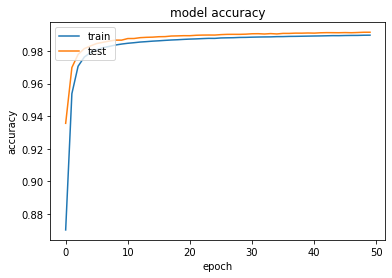

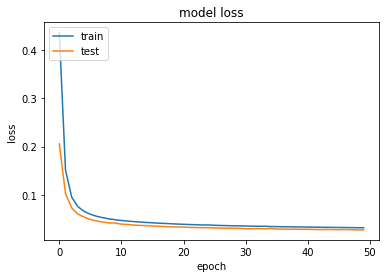

In [22]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
def actual_accuracy():
    rand_id = random.randint(0, len(corpus)-1)
    df = pd.DataFrame(corpus[ rand_id ])
    if len(df) > 20 :
        df = df[0:20]
    p = model.predict([ t.sequence_embedding(df[0]) ])
    df[2] = t.sentence_tags(p[0])[0:len(df)]
    #print(df)
    c = 0
    for index,row in df.iterrows():
        if row[1] == row[2] :
            c = c +1
    return c / len(df)
acc_s = []
for x in range(0,300):
    acc_s.append(actual_accuracy())
print( sum(acc_s)/len(acc_s))

0.9527149187385254


In [24]:
#saving the model
model.save('pos_model.h5')

In [ ]:
pred_set = [
    X_test[0],
]
pred_set = np.asarray(pred_set)
res=model.predict(pred_set)
print(Y_test[0][0])
print(res[0][0])